# Sentiment Analysis with an RNN

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Tutorials/blob/master/Keras-Tutorials/6.%20Sentiment%20Analysis/Sentiment%20Analysis.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Tutorials/blob/master/Keras-Tutorials/6.%20Sentiment%20Analysis/Sentiment%20Analysis.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

<img src="http://www.polyvista.com/blog/wp-content/uploads/2015/06/sentiment-customer-exp-large.png">
<p style="font-size:10px;">http://www.polyvista.com/blog/wp-content/uploads/2015/06/sentiment-customer-exp-large.png</p>

## What is Sentiment Analysis?

Sentiment Analysis also know as opinion mining refers to the identification, extraction and study of sentiment states by using natural language processing, text analysis, computational linguistics and biometrics.

## Sentiment Analysis with an Recurrent Neural Network

We will use a RNN for sentiment analysis because we care for the sequence in the data.

### Imports

In [3]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

### Loading in Dataset

In [ ]:
data = pd.read_csv('../data/raw/sentinment140-2/training.1600000.processed.noemoticon.csv', encoding='iso-8859-1', names=["SentimentCode", "Index", "Date", "Flag", "Username", "Text"])
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

In [7]:
newData = pd.read_csv('../data/raw/BTC_tweets_daily_example.csv', index_col = 0)
newData.shape
newData.head()




,Date,Tweet,Screen_name,Source,Link,Sentiment,sent_score,New_Sentiment_Score,New_Sentiment_State
0,Fri Mar 23 00:40:32 +0000 2018,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",myresumerocket,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['neutral'],0.0,0.000000,0.0
1,Fri Mar 23 00:40:34 +0000 2018,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,BitMocro,[u'Bitcoin'],"<a href=""http://twitter.com/download/android"" ...",['neutral'],0.0,0.000000,0.0
2,Fri Mar 23 00:40:35 +0000 2018,RT @tippereconomy: Another use case for #block...,hojachotopur,"[u'blockchain', u'Tipper', u'TipperEconomy']","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1.0,0.136364,1.0
3,Fri Mar 23 00:40:36 +0000 2018,free coins https://t.co/DiuoePJdap,denies_distro,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1.0,0.400000,1.0
4,Fri Mar 23 00:40:36 +0000 2018,RT @payvxofficial: WE are happy to announce th...,aditzgraha,[],"<a href=""http://twitter.com/download/android"" ...",['positive'],1.0,0.468182,1.0


### Labeling sementic for each entry
(0 = negative, 2 = neutral, 4 = positive)

In [ ]:
'''def f(row):
    if row['SentimentCode'] == 0:
        val = 'negative'
    elif row['SentimentCode'] == 2:
        val = 'neutral'
    else:
        val = 'positive'
    return val

data['Sentiment'] = data.apply(f, axis=1)

print(data.shape)
data.head()
'''



Removing all columns except the airline_sentiment and text column.

In [61]:
data = newData[['Sentiment', 'Tweet']]
data.head()
data.shape

(50887, 2)

Removing all rows with no sentinment value

In [66]:
data = data.drop(data[(data.Sentiment == 0) | (data.Sentiment != "['positive']") & (data.Sentiment != "['negative']") & (data.Sentiment != "['neutral']")].index)
data.shape

(50852, 2)

### Data exploration

<AxesSubplot:>

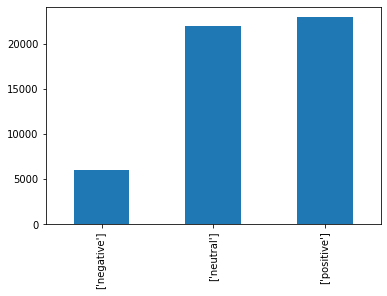

In [67]:
data['Sentiment'].value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

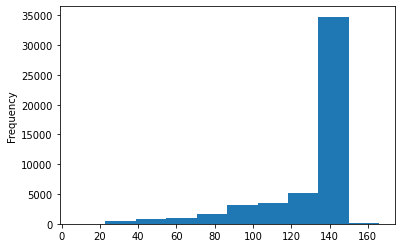

In [68]:
data['Tweet'].str.len().plot.hist()

### Preprocessing

In [69]:
data['Tweet'] = data['Tweet'].str.replace('@[\w]+', '')
#data.iloc[20:30]
data.info()
data = data.astype({"Tweet": "str"})


<class 'pandas.core.frame.DataFrame'>
Index: 50852 entries, 0 to 50858
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  50852 non-null  object
 1   Tweet      50852 non-null  object
dtypes: object(2)
memory usage: 3.2+ MB


/var/folders/qj/zhs6m1zd0dvg_v7rtzjt38n80000gn/T/ipykernel_13559/3898131742.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Tweet'] = data['Tweet'].str.replace('@[\w]+', '')


In [70]:
data['Tweet'].apply(lambda x: x.lower()) #transform text to lowercase
data['Tweet'] = data['Tweet'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
data['Tweet'].head()

0    RT  Paul Krugman Nobel Luddite I had to tweak ...
1        But  dum b a ss said you know nothing abou...
2    RT  Another use case for blockchain and Tipper...
3                        free coins httpstcoDiuoePJdap
4    RT  WE are happy to announce that PayVX Presal...
Name: Tweet, dtype: object

In [71]:
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(data['Tweet'].values)

X = tokenizer.texts_to_sequences(data['Tweet'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    2,   25,  310,    4,    3,
           7,   29,    1,  387,  266, 1203, 1002,  352,    3,  364,  920],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  139,  324,    5,  571,   12,  195, 1611,   44,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    2,  225,  198,  426,   11,   10,    6,  750,
           3,  841,   42,  881,  547,    6,   84,  493,   35,  108,  175],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   52,  199],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    2,   20,   

### Creating model

In [72]:
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [73]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 33, 256)           1280000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 33, 256)           525312    
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [74]:
y = pd.get_dummies(data['Sentiment']).values
[print(data['Sentiment'][i], y[i]) for i in range(0,5)]

['neutral'] [0 1 0]
['neutral'] [0 1 0]
['positive'] [0 0 1]
['positive'] [0 0 1]
['positive'] [0 0 1]


[None, None, None, None, None]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Training model

In [76]:
batch_size = 32
epochs = 8

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/8
1272/1272 - 375s - loss: 0.2138 - accuracy: 0.9287
Epoch 2/8
1272/1272 - 369s - loss: 0.0862 - accuracy: 0.9769
Epoch 3/8
1272/1272 - 344s - loss: 0.0614 - accuracy: 0.9818
Epoch 4/8
1272/1272 - 339s - loss: 0.0464 - accuracy: 0.9859
Epoch 5/8
1272/1272 - 748s - loss: 0.0350 - accuracy: 0.9894
Epoch 6/8
1272/1272 - 275s - loss: 0.0274 - accuracy: 0.9911
Epoch 7/8
1272/1272 - 272s - loss: 0.0206 - accuracy: 0.9936
Epoch 8/8
1272/1272 - 274s - loss: 0.0160 - accuracy: 0.9953


In [77]:
model.save('sentiment_analysis.h5')

### Testing model

In [8]:
model = load_model('sentiment_analysis.h5')

In [29]:
prodData = pd.read_csv('../data/interim/proddata.csv')

tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(prodData['Tweet'].values)

X_prod = tokenizer.texts_to_sequences(prodData['Tweet'].values)
X_prod = pad_sequences(X_prod) # padding our text vector so they all have the same length
X_prod[:5]

y_prod = pd.get_dummies(prodData['Sentiment']).values

[print(prodData['Sentiment'][i], y_prod[i]) for i in range(0,6)]

['positive'] [0 0 1]
['positive'] [0 0 1]
['negative'] [1 0 0]
['neutral'] [0 1 0]
['neutral'] [0 1 0]
['negative'] [1 0 0]


[None, None, None, None, None, None]

In [31]:
#predictions = model.predict(X_test)
predictions = model.predict(X_prod)

[print(prodData['Tweet'][i], predictions[i], y_prod[i]) for i in range(0,5)]

Bitcoin is going to the moon! [0.17667277 0.5438352  0.27949208] [0 0 1]
Cryptocurrency is going to be the future of financial system [0.01687921 0.9770997  0.006021  ] [0 0 1]
Bitcoin dump incoming… leave the market if you can [0.29853892 0.58256215 0.11889895] [1 0 0]
Market is going sideway at the current level. Nothing intersting is happening [0.17656025 0.30546957 0.5179702 ] [0 1 0]
Trade with me to get free bitcoin [0.13152792 0.00402765 0.8644444 ] [0 1 0]


[None, None, None, None, None]

In [18]:
pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neu_count += 1
    else:
        neg_count += 1
    
    if np.argmax(y_test[i])==2:
        real_pos += 1
    elif np.argmax(y_test[i])==1:    
        real_neu += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)

NameError: name 'y_test' is not defined

## Improvements we could implement
<ul>
    <li>Weight classes (because data is skew)</li>
    <li>Train more epochs</li>
    <li>Use bigger network</li>
    <li>Try other word number</li>
</ul>

## Resources

<ul>
    <li><a href="https://programmingwithgilbert.firebaseapp.com/videos/machine-learning-explained/recurrent-neural-networks-lstm-explained">Recurrent Neural Networks Explained (my own post and video)</a></li>
    <li><a href="https://en.wikipedia.org/wiki/Sentiment_analysis">Sentiment Analysis (Wikipedia)</a></li>
    <li><a href="https://www.quora.com/What-is-the-best-way-to-do-sentiment-analysis-with-Python-I%E2%80%99m-looking-for-a-sentiment-analysis-API-that-I-can-add-an-emoticon-dictionary-to-I-have-no-idea-how-to-use-NLTK-Can-anyone-help-me-with-that">What is the best way to do sentiment analysis with Python? (Quora)</a></li>
    <li><a href="https://www.youtube.com/watch?v=si8zZHkufRY">How to Do Sentiment Analysis (Siraj Raval)</a></li>
</ul>